In [2]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.ee import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
from src.data import shape_processor
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
from fastai.tabular.all import load_pickle, save_pickle, patch
from src.constants import DATA_PATH
from src.data import gedi_raster_matching
from src.processing.rf import split_data
from fastai.tabular.all import *
from sklearn.metrics import *
from src.utils.logging_util import get_logger
from sklearn.ensemble import RandomForestRegressor
from src.processing.rf import train

sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-06-25 13:26:40,002 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-25 13:26:40,003 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-25 13:26:40,004 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-25 13:26:40,005 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

In [3]:
gedi_recovery_2x2 = regen_analysis.process_all_fires_with_rf_control_per_burn_year(f"{DATA_PATH}/rf/burned/2x2", f"{DATA_PATH}/rf/models")

Process fires for year 1985.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1986.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1987.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1988.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1989.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1990.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1991.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1992.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1993.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1994.
matching shots within fire
Processi

In [4]:
filter_2x2 = gedi_recovery_2x2[(gedi_recovery_2x2.pft_class == 1)]

### Add Fire Metrics to the recovery

In [5]:
sierras_complex = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras_complex)
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")

In [6]:
# Get MTBS fire perimeters.
mtbs_perimeters = fire_perimeters.MTBSFirePerimetersDB(sierras)

In [7]:
perimeters = mtbs_perimeters.perimeters

In [8]:
filter_2x2 = filter_2x2.astype({'burn_year':'int'})
filter_2x2.burn_year

68024       1985
68147       1985
68278       1985
68394       1985
70227       1985
            ... 
27618965    2020
27618967    2020
27618975    2020
27624050    2020
27624051    2020
Name: burn_year, Length: 333021, dtype: int64

In [9]:
gedi_filtered = []
gedi_input = filter_2x2.copy()
count = 0
for perimeter in perimeters.itertuples():
    fire = perimeters[perimeters.index == perimeter.Index]
    print(fire.Ig_Date.dt.year.iloc[0])
    candidates = gedi_input[gedi_input.burn_year == fire.Ig_Date.dt.year.iloc[0]]
    within_perimeter = candidates.sjoin(fire, how="inner", predicate="within")

    if within_perimeter.empty:
        continue

    gedi_input = gedi_input[~gedi_input.index.isin(within_perimeter.index)]
    processed = regen_analysis.distance_to_perimeter(fire.geometry, within_perimeter)
    processed["fire_size"] = fire.BurnBndAc
    gedi_filtered.append(processed)

result = pd.concat(gedi_filtered)
print(result.shape[0])

1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1984
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1985
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1986
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1987
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1988
1989
1989
1989
1989
1989
1989
1989
1989
1989
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1991
1991
1991
1991
1991
1991
1991
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1993
1993
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994
1994


In [11]:
save_pickle(f"{DATA_PATH}/rf/recovery/gedi_2x2_recovery_with_fire_data.pkl", result)

In [12]:
filter_2x2.burn_count.unique()

array([1., 2., 3., 4., 5.])

In [13]:
result.columns

Index(['shot_number', 'longitude', 'latitude', 'agbd', 'agbd_pi_lower',
       'agbd_pi_upper', 'agbd_se', 'beam_type', 'sensitivity', 'pft_class',
       'gedi_year', 'gedi_month', 'absolute_time', 'geometry', 'severity',
       'burn_year', 'burn_count', 'time_since_burn', 'elevation', 'slope',
       'aspect', 'soil', 'agbd_control', 'rel_agbd', 'index_right', 'Event_ID',
       'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'FID',
       'distance_to_perimeter', 'fire_size'],
      dtype='object')

In [82]:
columns_to_use = ['severity', 'burn_count', 'time_since_burn', 'elevation', 'slope', 'aspect', 'soil', 'distance_to_perimeter', 'BurnBndAc', 'beam_type', 'sensitivity']

In [15]:
df = result[columns_to_use]

In [17]:
df.beam_type.unique()

array(['full', 'coverage'], dtype=object)

In [19]:
df['beam_type'] = df['beam_type'].astype('category')

In [21]:
df.beam_type

13791516        full
13791517        full
13791518        full
13809138        full
13809220    coverage
              ...   
12302450        full
12340879        full
12349701        full
12373386        full
19310561        full
Name: beam_type, Length: 323470, dtype: category
Categories (2, object): ['coverage', 'full']

In [22]:
df["beam_type"] = df['beam_type'].cat.set_categories(["full", "coverage"], ordered=True)

In [23]:
df.dtypes

rel_agbd                  float64
severity                  float64
burn_count                float64
time_since_burn           float64
elevation                 float32
slope                     float32
aspect                    float32
soil                      float32
distance_to_perimeter     float64
BurnBndAc                   int64
beam_type                category
sensitivity               float64
dtype: object

In [35]:
procs = [Categorify, FillMissing]

In [36]:
dep_var = 'rel_agbd'

In [37]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [38]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)

In [39]:
xs, y = to.train.xs, to.train.y

In [40]:
def rf(xs, y, n_estimators=100, max_samples=0.85,
       max_features=0.5, min_samples_leaf=30, max_leaf_nodes=None, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True, max_leaf_nodes=max_leaf_nodes).fit(xs, y)



In [41]:
m = rf(xs, y)

In [42]:
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

0.626103 0.3154382847222975


In [43]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [44]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
1,severity,0.476384
10,sensitivity,0.098367
5,slope,0.084061
4,elevation,0.080937
3,time_since_burn,0.063194
9,BurnBndAc,0.056611
8,distance_to_perimeter,0.049429
6,aspect,0.048018
0,beam_type,0.023480
7,soil,0.010904


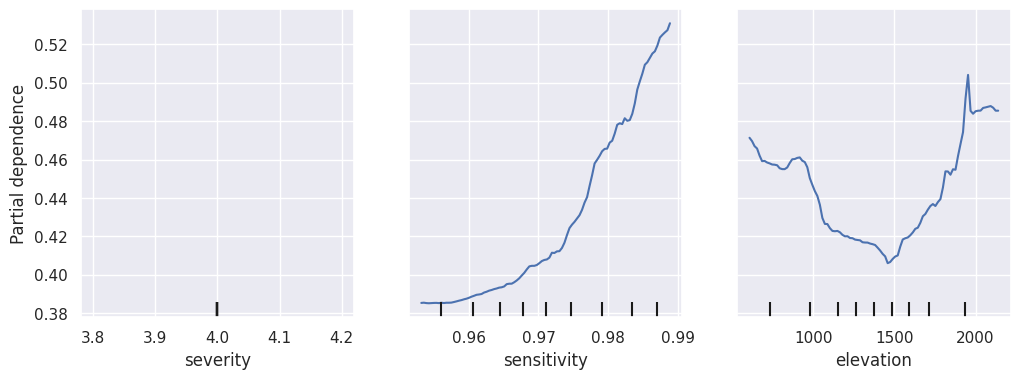

In [55]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['severity','sensitivity', 'elevation'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

### What governs recovery in low-severity burn areas

In [89]:
columns_to_use = ['agbd', 'severity', 'burn_count', 'time_since_burn', 'elevation', 'slope', 'aspect', 'soil', 'distance_to_perimeter', 'BurnBndAc', 'beam_type', 'sensitivity']

In [90]:
df = result[result.severity == 2][columns_to_use]

<Axes: xlabel='time_since_burn', ylabel='rel_agbd'>

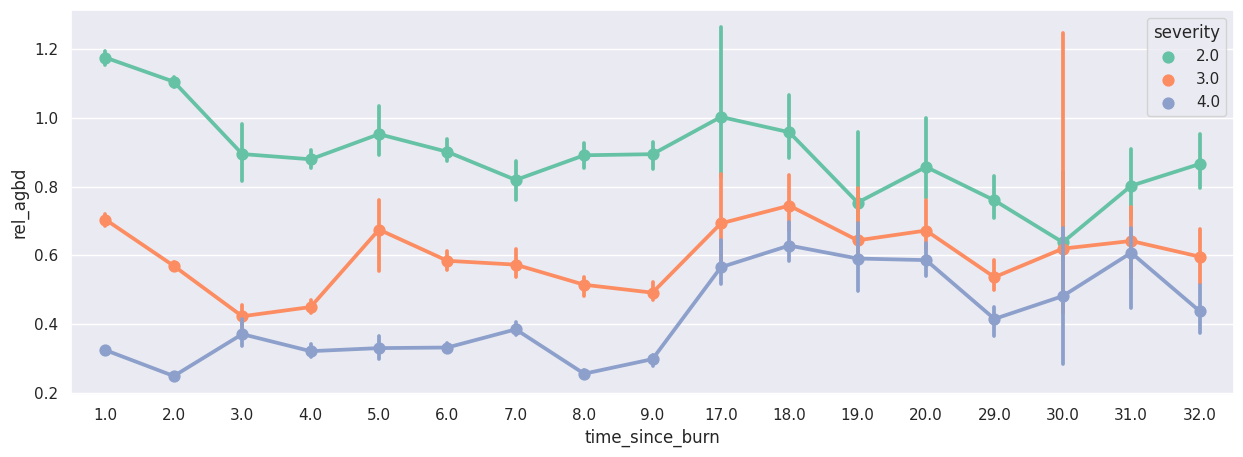

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.pointplot(result[result.BurnBndAc > 100000], x="time_since_burn", y="rel_agbd", hue="severity", ax=ax, palette="Set2", estimator="median")

<Axes: xlabel='time_since_burn', ylabel='agbd'>

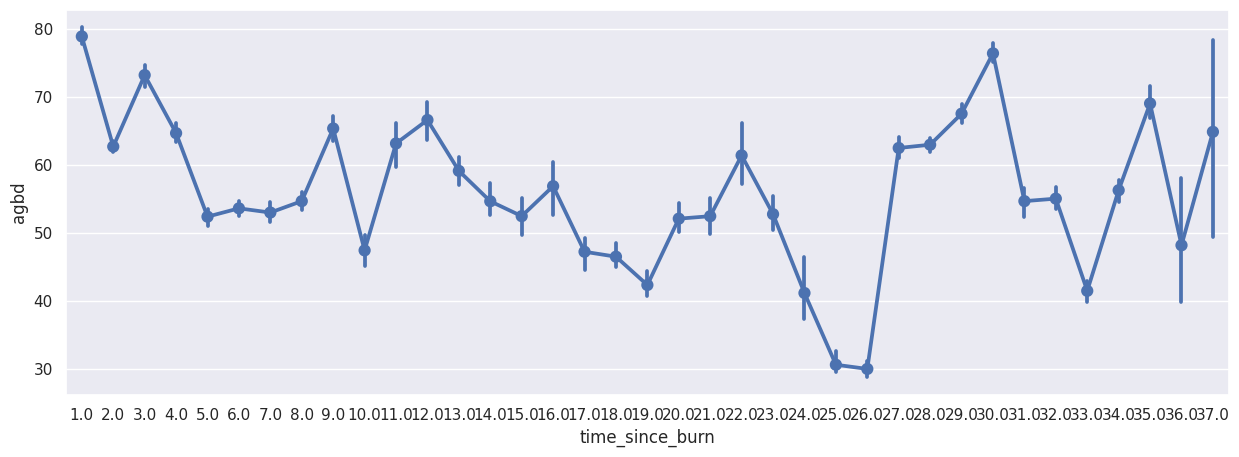

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.pointplot(result, x="time_since_burn", y="agbd", ax=ax, estimator="median")

<Axes: xlabel='BurnBndAc', ylabel='Count'>

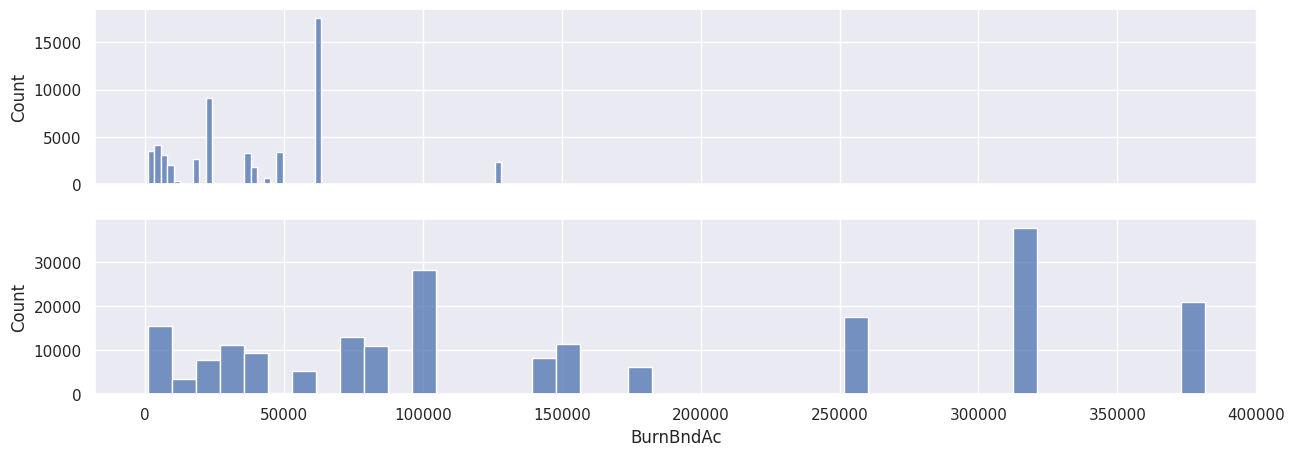

In [115]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
sns.histplot(result[result.time_since_burn.isin(range(25, 35))], x="BurnBndAc", ax=ax[0])
sns.histplot(result[result.time_since_burn.isin(range(1, 11))], x="BurnBndAc", ax=ax[1])

<Axes: >

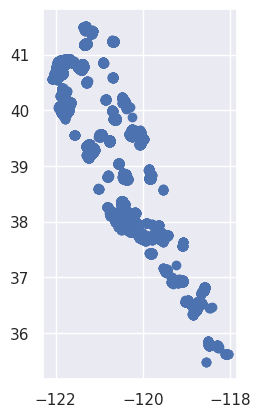

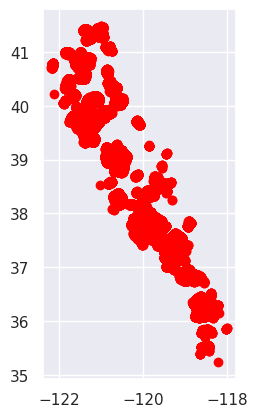

In [106]:
result[result.time_since_burn.isin(range(25, 35))].plot()
result[result.time_since_burn.isin(range(1, 11))].plot(color="red")

<Axes: xlabel='elevation', ylabel='Count'>

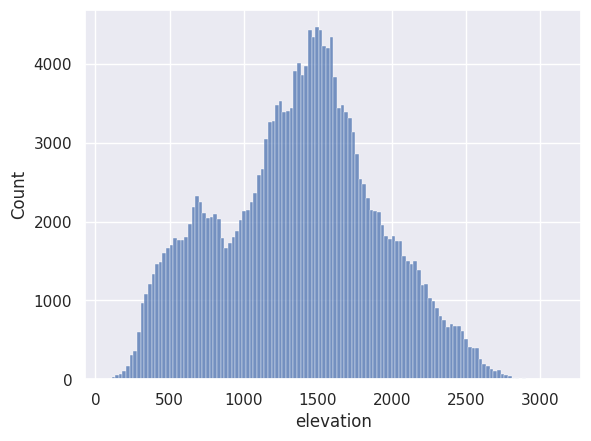

In [101]:
sns.histplot(result[result.time_since_burn.isin(range(1, 11))], x="elevation")

In [92]:
cont, cat = cont_cat_split(df, 1, dep_var="agbd")

In [93]:
to = TabularPandas(df, procs, cat, cont, y_names="agbd")

In [94]:
xs, y = to.train.xs, to.train.y

In [95]:
m = rf(xs, y)

In [96]:
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

115.040149 0.35811190208226684


In [97]:
fi = rf_feat_importance(m, xs)

<Axes: ylabel='cols'>

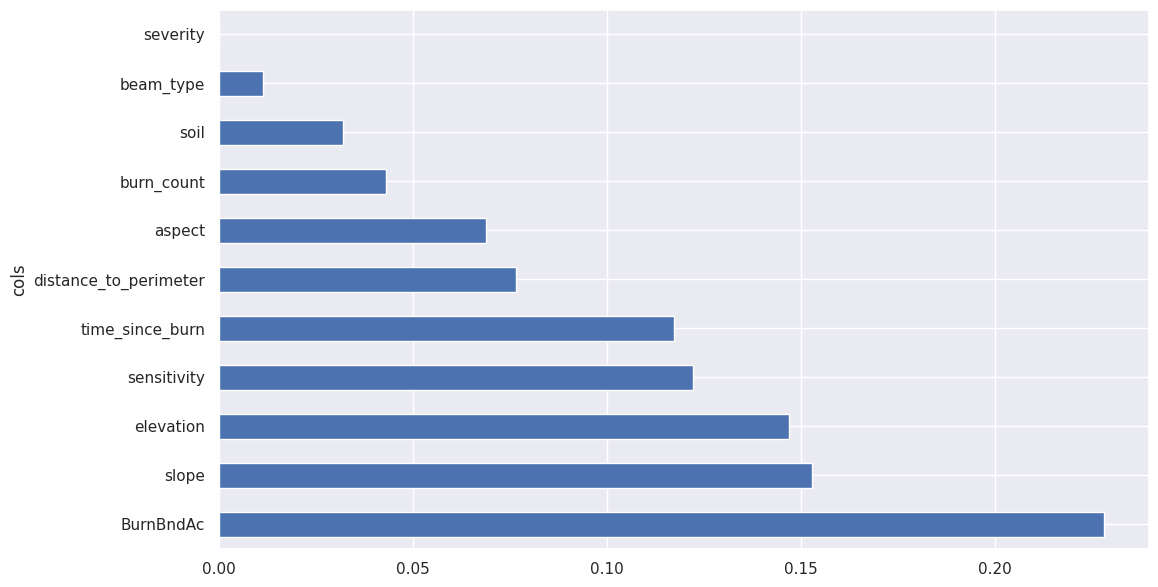

In [98]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30])

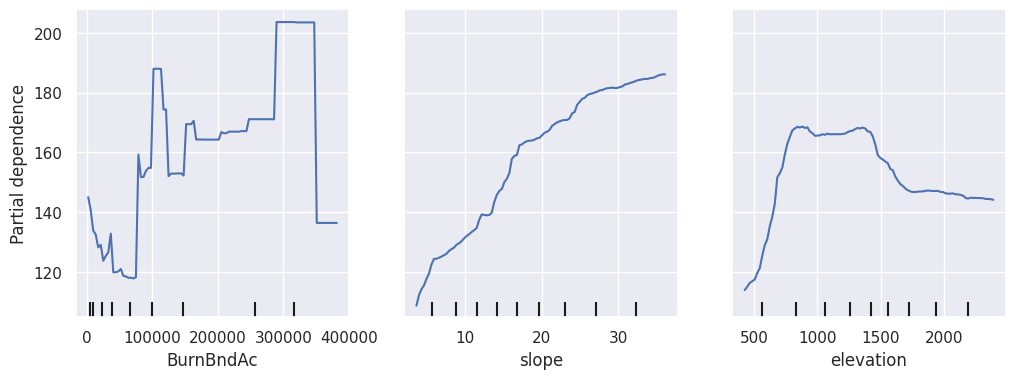

In [99]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['BurnBndAc', 'slope', 'elevation'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

### What governs recovery in high-severity burn areas

In [46]:
df = result[result.severity == 4][columns_to_use]

In [47]:
procs = [Categorify, FillMissing]

In [48]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [49]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)

In [50]:
xs, y = to.train.xs, to.train.y

In [51]:
m = rf(xs, y)

In [52]:
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

0.391139 0.2654970204033813


In [53]:
fi = rf_feat_importance(m, xs)

<Axes: ylabel='cols'>

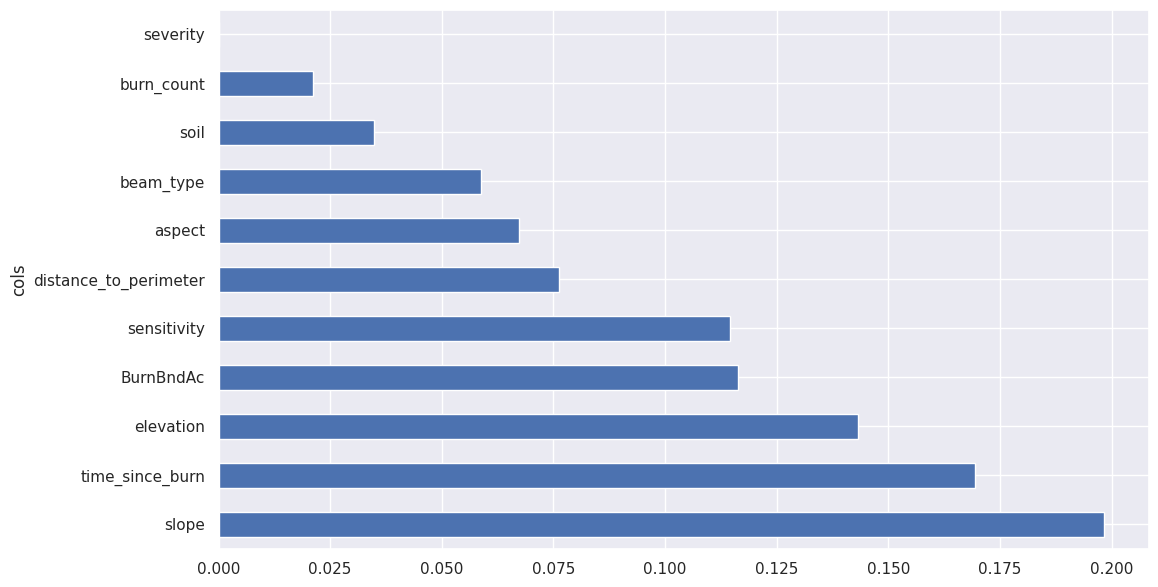

In [54]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30])

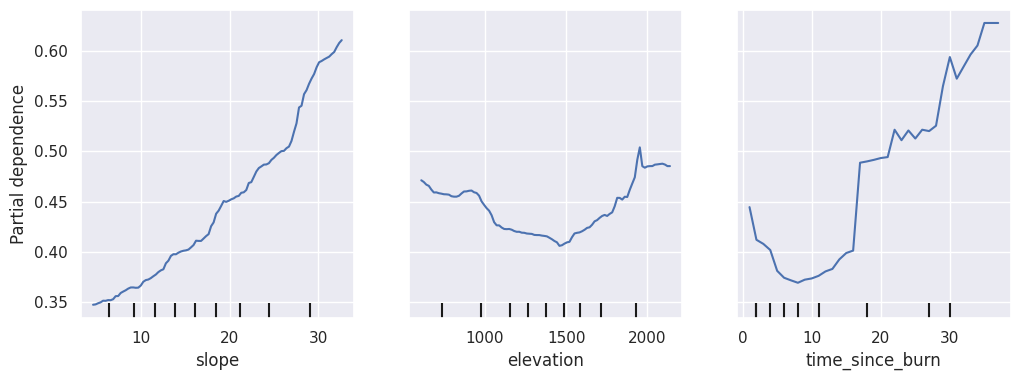

In [56]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['slope', 'elevation', 'time_since_burn'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

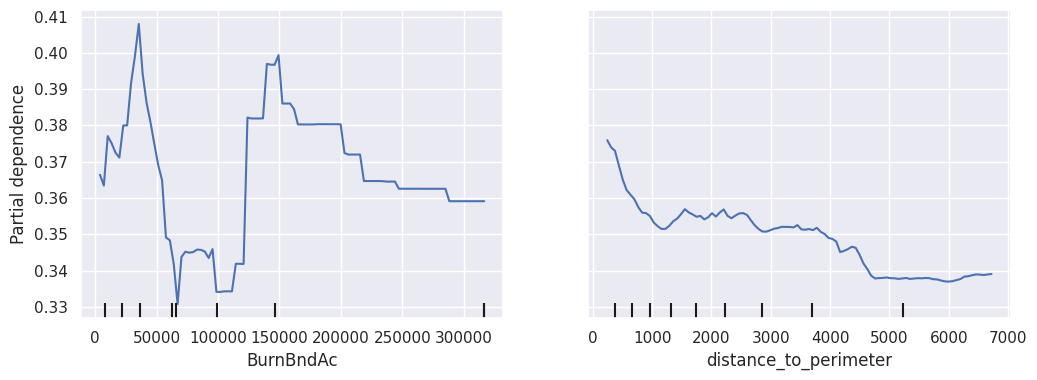

In [152]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['BurnBndAc', 'distance_to_perimeter'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

<Axes: xlabel='slope', ylabel='rel_agbd'>

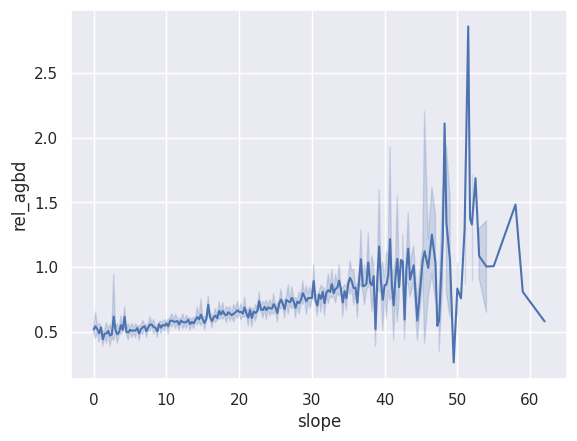

In [147]:
sns.lineplot(filter_2x2, x='slope', y='rel_agbd')

<Axes: xlabel='slope', ylabel='agbd'>

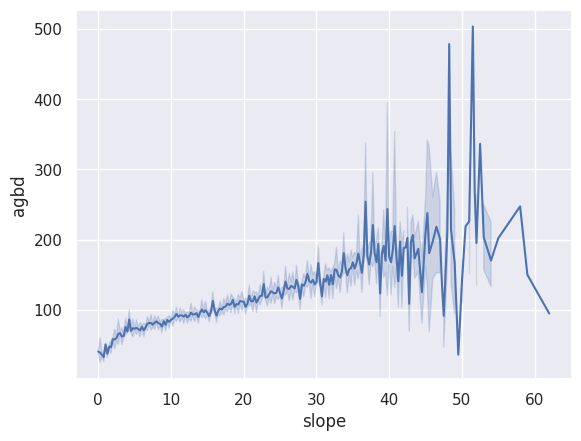

In [148]:
sns.lineplot(filter_2x2, x='slope', y='agbd')

In [149]:
filter_2x2.shape[0]

334072

In [151]:
filter_2x2[filter_2x2.slope < 35]

,shot_number,longitude,latitude,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,pft_class,...,severity,burn_year,burn_count,time_since_burn,elevation,slope,aspect,soil,agbd_control,rel_agbd
68024,73111100200078593,-120.746781,38.169353,188.598526,68.062080,369.264771,11.101941,full,0.987382,1,...,2.0,1985,1.0,35.0,388.0,19.0,53.0,0.0,110.720762,1.703371
68147,225020800200125443,-120.741764,38.159710,49.447220,2.394614,156.657501,11.107099,full,0.984889,1,...,2.0,1985,1.0,37.0,463.0,26.0,44.0,0.0,100.881105,0.490153
68278,20150200200125415,-120.747949,38.168811,167.028885,55.373684,338.802307,11.099805,coverage,0.981629,1,...,2.0,1985,1.0,34.0,434.0,26.0,47.0,0.0,104.033638,1.605528
68394,68231100200078604,-120.747240,38.170184,43.813046,1.289604,146.474823,11.103527,full,0.973560,1,...,2.0,1985,1.0,35.0,374.5,19.5,44.5,0.0,90.671608,0.483206
70227,42640800300287955,-120.742649,38.157309,59.594189,5.002278,174.315979,11.101964,full,0.977881,1,...,3.0,1985,1.0,34.0,544.0,18.0,50.0,0.0,119.778942,0.497535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27618965,225630800200085762,-119.550515,38.565973,19.979471,-9999.000000,99.098244,11.109340,full,0.965883,1,...,2.0,2020,1.0,2.0,2129.0,18.0,297.0,19.0,56.610620,0.352928
27618967,225630800200085764,-119.549511,38.566621,20.807606,-9999.000000,100.928558,11.108585,full,0.968726,1,...,3.0,2020,1.0,2.0,2137.5,11.0,14.0,19.0,73.762567,0.282089
27618975,225631100200080331,-119.554363,38.556271,131.316925,35.723694,287.024231,11.099050,full,0.994654,1,...,2.0,2020,1.0,2.0,2126.5,29.0,278.5,19.0,116.002419,1.132019
27624050,156220200200085334,-119.406297,38.528133,31.825970,0.024733,123.779739,11.106153,coverage,0.951131,1,...,4.0,2020,1.0,1.0,2413.0,17.0,230.0,19.0,56.043773,0.567877


In [69]:
filter_2x2[filter_2x2.sensitivity >= 0.98]

,shot_number,longitude,latitude,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,pft_class,...,severity,burn_year,burn_count,time_since_burn,elevation,slope,aspect,soil,agbd_control,rel_agbd
68024,73111100200078593,-120.746781,38.169353,188.598526,68.062080,369.264771,11.101941,full,0.987382,1,...,2.0,1985,1.0,35.0,349.50,27.978025,48.595634,5.0,104.655576,1.802088
68147,225020800200125443,-120.741764,38.159710,49.447220,2.394614,156.657501,11.107099,full,0.984889,1,...,2.0,1985,1.0,37.0,407.75,24.343815,40.636784,5.0,85.143038,0.580755
68278,20150200200125415,-120.747949,38.168811,167.028885,55.373684,338.802307,11.099805,coverage,0.981629,1,...,2.0,1985,1.0,34.0,395.25,19.176615,34.088627,5.0,73.914983,2.259743
70230,42640800300287960,-120.740148,38.155660,41.729271,0.952912,142.646408,11.103981,full,0.989156,1,...,2.0,1985,1.0,34.0,490.25,25.600327,49.037056,5.0,100.801766,0.413974
70231,42640800300287961,-120.739647,38.155329,73.579910,9.573811,197.728287,11.104256,full,0.990597,1,...,2.0,1985,1.0,34.0,494.25,24.271040,37.228470,5.0,91.833216,0.801234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27618961,225630800200085750,-119.556617,38.562016,25.428875,-9999.000000,110.820412,11.107120,full,0.988594,1,...,2.0,2020,1.0,2.0,1999.75,20.231812,304.895966,5.0,44.658816,0.569403
27618962,225630800200085753,-119.555093,38.563005,29.448746,-9999.000000,119.044731,11.105783,full,0.986837,1,...,2.0,2020,1.0,2.0,2040.25,23.786390,300.903625,5.0,59.012584,0.499025
27618963,225630800200085757,-119.553059,38.564323,122.198563,31.039167,273.485962,11.101624,full,0.988854,1,...,2.0,2020,1.0,2.0,2089.25,30.959230,292.101929,5.0,81.290991,1.503224
27618964,225630800200085760,-119.551527,38.565317,28.583668,-9999.000000,117.301216,11.106215,full,0.983052,1,...,2.0,2020,1.0,2.0,2110.25,24.563042,283.184570,5.0,59.969965,0.476633


In [68]:
filter_2x2.shape

(333021, 24)

<Axes: xlabel='time_since_burn', ylabel='rel_agbd'>

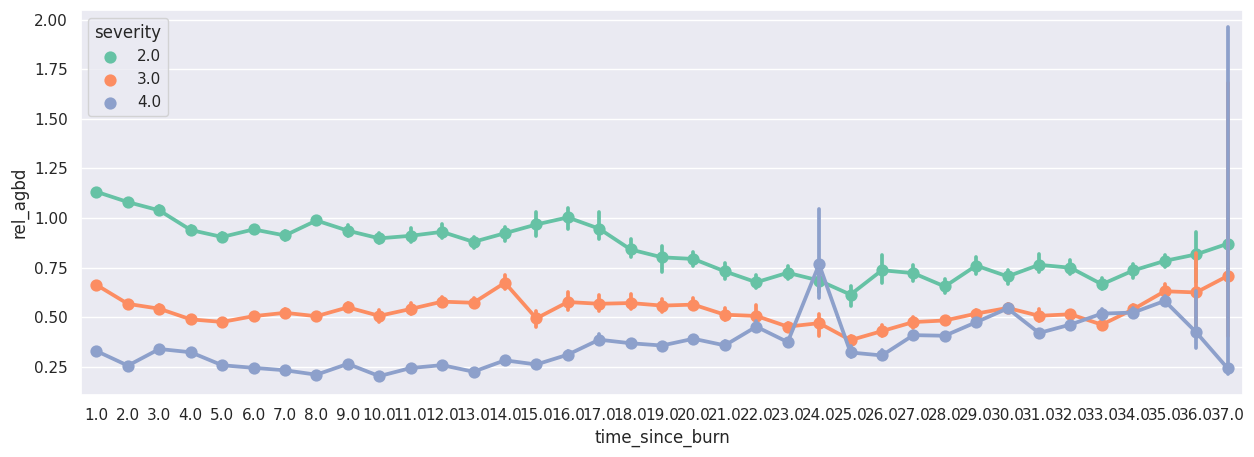

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.pointplot(filter_2x2, x="time_since_burn", y="rel_agbd", hue="severity", ax=ax, palette="Set2", estimator="median")